In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys
import json
import os
from PIL import Image
from sklearn.utils import shuffle
from tqdm import tqdm

In [2]:
from numpy import array
import pandas as pd
import tensorflow as tf
import string 
import glob
import pickle
from time import time
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, \
                        Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import add
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.python.keras.backend import set_session

In [7]:
# Downloading Caption for images
caption_folder = '/captions/'
if not os.path.exists(os.path.abspath('.')+caption_folder):
    caption_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
    caption_file = os.path.dirname(caption_zip)+'/captions/captions_train2014.json'
    os.remove(caption_zip)
    
# Download Images
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.')+image_folder):
    image_zip = tf.keras.utils.get_file('train2014.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin='http://images.cocodataset.org/zips/train2014.zip',
                                          extract = True)
    image_file = os.path.dirname(image_zip)+image_folder
    os.remove(image_zip)
else:
    image_file = os.path.abspath('.') + image_folder

13510582272/13510573713 [==============================] - 3806s 0us/step


In [3]:
# Reading the JSON file 
caption_file = 'annotations/captions_train2014.json'
with open(caption_file, 'r') as f:
    captions = json.load(f)
all_captions = []
all_img_name_vector = []

for cap in captions['annotations']:
    caption = cap['caption']
    image_id = cap['image_id']
    full_coco_image_path = 'COCO_train2014_'+'%012d.jpg'%(image_id)
    
    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)
    
# Shuffle captions and image_names together
# Set a random state
train_captions_1, img_name_vector_1 = shuffle(all_captions,all_img_name_vector,random_state=1)

# Select and Display first 30000 captions from the shuffled set

num_examples = 30000
train_captions = train_captions_1[:num_examples]
img_name_vector = img_name_vector_1[:num_examples]
train_captions

['A skateboarder performing a trick on a skateboard ramp.',
 'a person soaring through the air on skis',
 'a wood door with some boards laid against it',
 'A Do Not Enter sign is posted along a road leading to a stadium.',
 'Small child in a high chair eating off of a green plate. ',
 'groups of people standing around the toilet area',
 'a hand is holding a black and silver cellphone',
 'People working on laptop computers in a student dining room',
 'two birds near one another in a field ',
 'A man talking on a cell phone in a park.',
 'A group of men standing around a table with microphones while one makes a speech.',
 'A bathroom with a toilet and sprayer attached to the wall.',
 'A woman sitting on a wooden bench talking on a phone.',
 'A woman with a clock on her purse at the market.',
 'The surfer is offering his favorite hand signal.',
 'A small cat is sitting on some asphalt.',
 'Two peeled carrots next with cut up squash and cut up carrots next to them.',
 'Traffic lights at an

In [4]:
#Preparing test set 
test_captions = train_captions_1[num_examples:35000]
test_img_name_vector = img_name_vector_1[num_examples:35000]

In [5]:
descriptions = dict()
for i in range(len(img_name_vector)):
    if img_name_vector[i] not in descriptions:
        descriptions[img_name_vector[i]] = list()
    descriptions[img_name_vector[i]].append(train_captions[i])

In [41]:
list(descriptions.keys())[:5]

['COCO_train2014_000000324909.jpg',
 'COCO_train2014_000000511972.jpg',
 'COCO_train2014_000000508809.jpg',
 'COCO_train2014_000000270497.jpg',
 'COCO_train2014_000000008014.jpg']

In [62]:
descriptions['COCO_train2014_000000270497.jpg']

['A Do Not Enter sign is posted along a road leading to a stadium.']

In [6]:
# Removing punctuations and create a translation table
def clean_descriptions(descriptions):
    table = str.maketrans('','',string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            #tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuations from each token
            desc = [w.translate(table) for w in desc]
            # remove tokens with number in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i]= ' '.join(desc)
            
clean_descriptions(descriptions)

In [67]:
descriptions['COCO_train2014_000000270497.jpg']

['a do not enter sign is posted along a road leading to a stadium']

In [7]:
# building a list of all description strings
def to_vocabulary(descriptions):
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

#summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d ' % len(vocabulary))


Original Vocabulary Size: 8181 


In [8]:
# save the vocabulary 
def save_descriptions(descriptions,filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key+' '+desc)
    data = '\n'.join(lines)
    file = open(filename,'w')
    file.write(data)
    file.close()
    
save_descriptions(descriptions,'descriptions.txt')

In [9]:
# Create a list of all image names in the directory
images = 'train2014/'
img = glob.glob(images+'*.jpg')
img

['train2014\\COCO_train2014_000000000009.jpg',
 'train2014\\COCO_train2014_000000000025.jpg',
 'train2014\\COCO_train2014_000000000030.jpg',
 'train2014\\COCO_train2014_000000000034.jpg',
 'train2014\\COCO_train2014_000000000036.jpg',
 'train2014\\COCO_train2014_000000000049.jpg',
 'train2014\\COCO_train2014_000000000061.jpg',
 'train2014\\COCO_train2014_000000000064.jpg',
 'train2014\\COCO_train2014_000000000071.jpg',
 'train2014\\COCO_train2014_000000000072.jpg',
 'train2014\\COCO_train2014_000000000077.jpg',
 'train2014\\COCO_train2014_000000000078.jpg',
 'train2014\\COCO_train2014_000000000081.jpg',
 'train2014\\COCO_train2014_000000000086.jpg',
 'train2014\\COCO_train2014_000000000089.jpg',
 'train2014\\COCO_train2014_000000000092.jpg',
 'train2014\\COCO_train2014_000000000094.jpg',
 'train2014\\COCO_train2014_000000000109.jpg',
 'train2014\\COCO_train2014_000000000110.jpg',
 'train2014\\COCO_train2014_000000000113.jpg',
 'train2014\\COCO_train2014_000000000127.jpg',
 'train2014\\

In [10]:
with open ('img_files.txt','w') as f:
    for item in img:
        f.write("%s\n"%item)

In [11]:
train_img=[]
for i in img:
    if i[len(images):] in img_name_vector:
        train_img.append(i)
train_img

['train2014\\COCO_train2014_000000000025.jpg',
 'train2014\\COCO_train2014_000000000049.jpg',
 'train2014\\COCO_train2014_000000000077.jpg',
 'train2014\\COCO_train2014_000000000078.jpg',
 'train2014\\COCO_train2014_000000000081.jpg',
 'train2014\\COCO_train2014_000000000092.jpg',
 'train2014\\COCO_train2014_000000000109.jpg',
 'train2014\\COCO_train2014_000000000165.jpg',
 'train2014\\COCO_train2014_000000000250.jpg',
 'train2014\\COCO_train2014_000000000389.jpg',
 'train2014\\COCO_train2014_000000000419.jpg',
 'train2014\\COCO_train2014_000000000438.jpg',
 'train2014\\COCO_train2014_000000000450.jpg',
 'train2014\\COCO_train2014_000000000510.jpg',
 'train2014\\COCO_train2014_000000000514.jpg',
 'train2014\\COCO_train2014_000000000542.jpg',
 'train2014\\COCO_train2014_000000000560.jpg',
 'train2014\\COCO_train2014_000000000572.jpg',
 'train2014\\COCO_train2014_000000000575.jpg',
 'train2014\\COCO_train2014_000000000581.jpg',
 'train2014\\COCO_train2014_000000000605.jpg',
 'train2014\\

In [12]:
test_img=[]
for i in img:
    if i[len(images):] in test_img_name_vector:
        test_img.append(i)
test_img

['train2014\\COCO_train2014_000000000071.jpg',
 'train2014\\COCO_train2014_000000000081.jpg',
 'train2014\\COCO_train2014_000000000490.jpg',
 'train2014\\COCO_train2014_000000000612.jpg',
 'train2014\\COCO_train2014_000000000706.jpg',
 'train2014\\COCO_train2014_000000000735.jpg',
 'train2014\\COCO_train2014_000000000909.jpg',
 'train2014\\COCO_train2014_000000000913.jpg',
 'train2014\\COCO_train2014_000000000996.jpg',
 'train2014\\COCO_train2014_000000001261.jpg',
 'train2014\\COCO_train2014_000000001264.jpg',
 'train2014\\COCO_train2014_000000001527.jpg',
 'train2014\\COCO_train2014_000000001674.jpg',
 'train2014\\COCO_train2014_000000001786.jpg',
 'train2014\\COCO_train2014_000000001924.jpg',
 'train2014\\COCO_train2014_000000002024.jpg',
 'train2014\\COCO_train2014_000000002055.jpg',
 'train2014\\COCO_train2014_000000002281.jpg',
 'train2014\\COCO_train2014_000000002347.jpg',
 'train2014\\COCO_train2014_000000002372.jpg',
 'train2014\\COCO_train2014_000000002429.jpg',
 'train2014\\

In [13]:
def load_doc(filename):
    file = open(filename,'r')
    text = file.read()
    file.close()
    return text


In [14]:
def load_clean_descriptions(filename,dataset):
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
                # wrap descriptions in tokens
                desc = 'startseq '+' '.join(image_desc)+' endseq'
                # store
                descriptions[image_id].append(desc)
    return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt',img_name_vector)
print('Descriptions: train=%d'%len(train_descriptions))

Descriptions: train=25950


In [15]:
# Fucntion for preprocessing data
def preprocess(image_path):
    # image conversion to 299x299 required by inception v3 model
    img = image.load_img(image_path,target_size=(299,299))
    # Convert PIL to numpy-array of 3 dimensions
    x = image.img_to_array(img)
    # Adding one more dimension
    x = np.expand_dims(x,axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [16]:
model = InceptionV3(weights='imagenet')

In [17]:
model_new = Model(model.input,model.layers[-2].output)

In [18]:
#Function for Encoding the image
def encode(image):
    image = preprocess(image)
    fea_vec = model_new.predict(image) # Encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1,2048) to (2048, )
    return fea_vec

In [19]:
start = time()
encoding_train = {}
for img in tqdm(train_img):
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

100%|██████████████████████████████████████████████████████████████████████████| 25950/25950 [1:49:14<00:00,  3.96it/s]

Time taken in seconds = 6554.286475658417


In [25]:
train_img[0]

'train2014\\COCO_train2014_000000000025.jpg'

In [26]:
encoding_train

{'COCO_train2014_000000000025.jpg': array([0.22710429, 0.33991608, 0.25934893, ..., 0.18872763, 0.2588881 ,
        0.1660054 ], dtype=float32),
 'COCO_train2014_000000000049.jpg': array([0.1948374 , 0.14706364, 0.1657693 , ..., 0.19200794, 0.2922381 ,
        0.5584262 ], dtype=float32),
 'COCO_train2014_000000000077.jpg': array([0.9306984 , 0.09830096, 0.44088364, ..., 1.0217879 , 0.40153608,
        0.2785542 ], dtype=float32),
 'COCO_train2014_000000000078.jpg': array([0.11315712, 0.17526226, 0.7561626 , ..., 0.20449023, 0.16530539,
        0.35663256], dtype=float32),
 'COCO_train2014_000000000081.jpg': array([0.10560447, 0.19208199, 0.03835766, ..., 0.2697105 , 0.12896758,
        0.8410147 ], dtype=float32),
 'COCO_train2014_000000000092.jpg': array([0.11211119, 0.26553887, 0.5462842 , ..., 0.9761888 , 0.18719803,
        0.05058349], dtype=float32),
 'COCO_train2014_000000000109.jpg': array([0.02373367, 0.2725386 , 0.5220648 , ..., 0.21178634, 0.21764605,
        0.49255937], d

In [20]:
with open("encoded_train_images.pkl","wb") as encoded_pickle:
    pickle.dump(encoding_train,encoded_pickle)

In [21]:
start = time()
encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

100%|██████████████████████████████████████████████████████████████████████████████| 4870/4870 [19:30<00:00,  4.16it/s]

Time taken in seconds = 1170.8739936351776


In [51]:
test_img

['train2014\\COCO_train2014_000000000071.jpg',
 'train2014\\COCO_train2014_000000000081.jpg',
 'train2014\\COCO_train2014_000000000490.jpg',
 'train2014\\COCO_train2014_000000000612.jpg',
 'train2014\\COCO_train2014_000000000706.jpg',
 'train2014\\COCO_train2014_000000000735.jpg',
 'train2014\\COCO_train2014_000000000909.jpg',
 'train2014\\COCO_train2014_000000000913.jpg',
 'train2014\\COCO_train2014_000000000996.jpg',
 'train2014\\COCO_train2014_000000001261.jpg',
 'train2014\\COCO_train2014_000000001264.jpg',
 'train2014\\COCO_train2014_000000001527.jpg',
 'train2014\\COCO_train2014_000000001674.jpg',
 'train2014\\COCO_train2014_000000001786.jpg',
 'train2014\\COCO_train2014_000000001924.jpg',
 'train2014\\COCO_train2014_000000002024.jpg',
 'train2014\\COCO_train2014_000000002055.jpg',
 'train2014\\COCO_train2014_000000002281.jpg',
 'train2014\\COCO_train2014_000000002347.jpg',
 'train2014\\COCO_train2014_000000002372.jpg',
 'train2014\\COCO_train2014_000000002429.jpg',
 'train2014\\

In [22]:
with open("encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [23]:
train_features = pickle.load(open("encoded_train_images.pkl","rb"))
print('Photos: train=%d '%len(train_features))

Photos: train=25950 


In [24]:
if os.path.getsize("encoded_test_images.pkl")>0:
    with open("encoded_test_images.pkl","rb") as f:
        unpickler = pickle.Unpickler(f)
        test_features = unpickler.load()
    print('Photos: train=%d '%len(test_features))
        

Photos: train=4870 


In [25]:
all_train_captions=[]
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

25950

In [29]:
word_counts_threshold = 10
word_counts={}
nsents = 0
for sent in all_train_captions:
    nsents+=1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w,0)+1

vocab = [w for w in word_counts if word_counts[w] >= word_counts_threshold]
print('preprocessed words %d -> %d'%(len(word_counts),len(vocab)))

preprocessed words 7728 -> 1570


In [30]:
ixtoword={}
wordtoix={}

ix = 1
for w in vocab:
    wordtoix[w]=ix
    ixtoword[ix]=w
    ix+=1

In [31]:
with open ('wordtoix.p','wb') as fp:
    pickle.dump(wordtoix, fp, protocol=pickle.HIGHEST_PROTOCOL)
with open ('ixtoword.p','wb') as fp:
    pickle.dump(ixtoword, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [32]:
vocab_size = len(ixtoword) + 1 # one for appends 0's
vocab_size

1571

In [34]:
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description length: %d ' % max_length)

Description length: 49 


In [92]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key]
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield ((array(X1), array(X2))),(array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [39]:
# glove.6B.200d.txt is a seperate dataset downloaded externally
glove_dir = ''
embeddings_index = {}#empty dictionary
f = open(os.path.join(glove_dir,'glove.6B.200d.txt'),encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vector.' % len(embeddings_index))

Found 400000 word vector.


In [43]:
embedding_dim = 200

#Get 200-dim dense vector for each of the 1000 words in output dictionary
embedding_matrix = np.zeros((vocab_size,embedding_dim))

for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector
        

In [96]:
# Defining model 
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256,activation='relu')(fe1)
inputs2 = Input(shape =(max_length,))
se1 = Embedding(vocab_size,embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256,return_sequences = False)(se2)
decoder1 = add([fe2,se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [97]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 49)]         0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 49, 200)      314200      input_17[0][0]                   
__________________________________________________________________________________________________
dropout_14 (Dropout)            (None, 2048)         0           input_16[0][0]                   
____________________________________________________________________________________________

In [98]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [102]:
model.compile(loss='categorical_crossentropy',optimizer='adam')

In [100]:
epochs = 5
number_of_img_per_batch = 3
steps = len(train_descriptions)//number_of_img_per_batch

In [103]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_of_img_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('model_' + str(i) + '.h5')
    print(i)

8650/8650 [==============================] - 1202s 138ms/step - loss: 3.5837
0


c:\python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


8650/8650 [==============================] - 1134s 131ms/step - loss: 2.9924
1
8650/8650 [==============================] - 1215s 140ms/step - loss: 2.8526
2
8650/8650 [==============================] - 1121s 130ms/step - loss: 2.7863
3
8650/8650 [==============================] - 1011s 117ms/step - loss: 2.7480
4


In [107]:
model.optimizer.learning_rate=0.0001
epochs = 10
number_of_images_per_batch = 6
steps = len(train_descriptions)//number_of_images_per_batch

In [108]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_of_images_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

4325/4325 [==============================] - 723s 167ms/step - loss: 2.4864s 


In [109]:
with open ("encoded_test_images.pkl","rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)

In [110]:
encoding_test.keys()

dict_keys(['COCO_train2014_000000000071.jpg', 'COCO_train2014_000000000081.jpg', 'COCO_train2014_000000000490.jpg', 'COCO_train2014_000000000612.jpg', 'COCO_train2014_000000000706.jpg', 'COCO_train2014_000000000735.jpg', 'COCO_train2014_000000000909.jpg', 'COCO_train2014_000000000913.jpg', 'COCO_train2014_000000000996.jpg', 'COCO_train2014_000000001261.jpg', 'COCO_train2014_000000001264.jpg', 'COCO_train2014_000000001527.jpg', 'COCO_train2014_000000001674.jpg', 'COCO_train2014_000000001786.jpg', 'COCO_train2014_000000001924.jpg', 'COCO_train2014_000000002024.jpg', 'COCO_train2014_000000002055.jpg', 'COCO_train2014_000000002281.jpg', 'COCO_train2014_000000002347.jpg', 'COCO_train2014_000000002372.jpg', 'COCO_train2014_000000002429.jpg', 'COCO_train2014_000000002567.jpg', 'COCO_train2014_000000002639.jpg', 'COCO_train2014_000000002843.jpg', 'COCO_train2014_000000002951.jpg', 'COCO_train2014_000000003077.jpg', 'COCO_train2014_000000003160.jpg', 'COCO_train2014_000000003518.jpg', 'COCO_tra

In [111]:
# Greedy search function to find the description of the image

def greedySearch(image):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence],maxlen=max_length)
        image = np.array(image)
        sequence = np.array(sequence)
        yhat = model.predict([image,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text +=' '+word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final =' '.join(final)
    return final

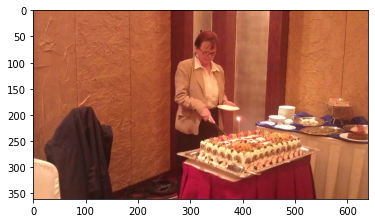

a man is holding a knife and a cake


In [112]:
pic = list(encoding_test.keys())[5]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print(greedySearch(image))